# Clustering

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.linalg as lin
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from cs771 import utils
import random

**Generating Toy Data** this dataset will have a collection of several data points that are clearly arranged in separate clusters. Each cluster will be simply a set of points in a circular arrangement. We will use this simple dataset to study the convergence behavior of the kmeans clustering algorithm.

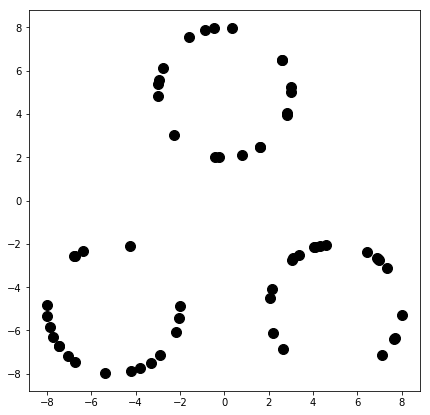

In [3]:
d = 2 
n = 20
r = 3

mu1 = np.array( [0,5] )
mu2 = np.array( [-5,-5] )
mu3 = np.array( [5,-5] )

tmp1 = gsd.genSphericalData( d, n, mu1, r )
tmp2 = gsd.genSphericalData( d, n, mu2, r )
tmp3 = gsd.genSphericalData( d, n, mu3, r )
X = np.vstack( (tmp1, tmp2, tmp3) )

fig = pd.getFigure( 7, 7 )
pd.plot2D( X, fig, color = 'k', marker = 'o' )

**Implementing the Llyod's Algorithm**: let us first implement the Llyod's algorithm and see how it performs. The Llyod's algorithm simply requires us to alternately assign every data point to the closest centroid and then update the centroids to the mean of the data points assigned to them.

In [4]:
# For every point, return which is the closest centroid
def getClosestCentroid( X, muVals ):
    return np.argmin( utils.getAllPairsDistances( X, muVals ), axis = 1 )

# Update every centroid to the mean of all data points assigned to that cluster
def updateCentroids( X, z, k, prevMuVals ):
    muVals = np.zeros( (k, X.shape[1]) )
    for i in range( k ):
        if z[z == i].size > 0:
            muVals[i,:] = np.mean( X[z == i,:], axis = 0 )
        # If some cluster is empty, return the old value of its centroid
        else:
            muVals[i,:] = prevMuVals[i,:]
    return muVals

# Execute the Llyod's algorithm
def dokmeans( X, k, init, niter ):
    muVals = init
    # Perform alternating minimization for niter steps
    for t in range( niter ):
        z = getClosestCentroid( X, muVals )
        muVals = updateCentroids( X, z, k, muVals )
    return (muVals, z)

**Initialization Issues**: the Lloyd's algorithm is very sensitive to initialization, more so in higher dimensions and when data is not very cleanly clustered. Even in this toy case where data is indeed cleanly clustered, a particularly bad initialization will force the algorithm to get stuck with a bad solution.

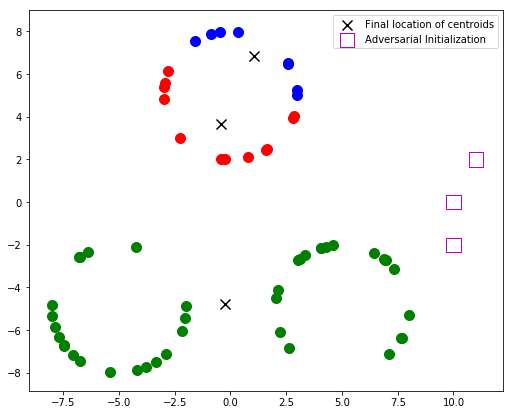

In [5]:
k = 3
# Random initializations are popular for k-means
# init = np.random.normal( 0, 1, (k,d) )
# Adversarial initializations can cause k-means to get stuck in bad assignments
init = np.array( [[10,0], [10,-2], [11,2]] )
# No matter how long we run the algorithm, it does not get unstuck
(muVals, z) = dokmeans( X, 3, init, 1000)

fig2 = pd.getFigure( 8.5, 7 )
pd.plot2D( X[z == 0], fig2, color = 'r', marker = 'o' )
pd.plot2D( X[z == 1], fig2, color = 'g', marker = 'o' )
pd.plot2D( X[z == 2], fig2, color = 'b', marker = 'o' )
pd.plot2D( muVals, fig2, color = 'k', marker = 'x', label = "Final location of centroids" )
pd.plot2D( init, fig2, color = 'm', marker = 's', size = 200, empty = True, label = "Adversarial Initialization" )

To avoid bad initializations, it is common to use random initializations and hope that we do not get unlucky. One such technique to perform a provably good initialization is the so-called k-means++ algorithm. Note that k-means++ is not an algorithm to perform clustering itself. It is simply an algorithm to initialize the Lloyd's algorithm properly.

**Reference**\
David Arthur and Sergei Vassilvitskii, _k-means++: The Advantages of Careful Seeding_ , Proceedings of the 18th Annual ACM-SIAM Symposium on Discrete Algorithms (SODA), pp 1027–-1035, 2007.

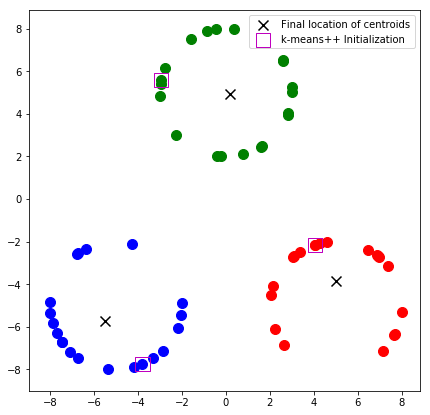

In [6]:
# Perform the k-means++ initialization
def doKMPPInit( X, k ):
    init = np.zeros( (k, X.shape[1]) )
    n = X.shape[0]
    # Choose a random data point and make it a centroid
    i = random.randint( 0, n-1 )
    init[0,:] = X[i,:]
    for t in range( 1, k ):
        # For all data points, find the squared Euclidean distance to the closest centroid
        # Python is funny, the statement init[0,:] generates a vector but init[0:1,:] generates a matrix with one row :)
        dist = np.min( utils.getAllPairsDistances( X, init[0:t,:] ), axis = 1 )
        # Choose the next centroid to be one that is likely to be far from all currently chosen centroids
        probs = dist/np.sum(dist)
        # Numerical issues in Python may cause ||x-x||_2 to not be exactly zero
        probs[probs < 1e-10] = 0
        i = np.random.choice( np.arange( n ), p = probs )
        init[t,:] = X[i,:]
        
    return init

# Do the k-means++ initialization this time
initkmpp = doKMPPInit( X, k )
(muVals, z) = dokmeans( X, 3, initkmpp, 10)

fig3 = pd.getFigure( 7, 7 )
pd.plot2D( X[z == 0], fig3, color = 'r', marker = 'o' )
pd.plot2D( X[z == 1], fig3, color = 'g', marker = 'o' )
pd.plot2D( X[z == 2], fig3, color = 'b', marker = 'o' )
pd.plot2D( muVals, fig3, color = 'k', marker = 'x', label = "Final location of centroids" )
pd.plot2D( initkmpp, fig3, color = 'm', marker = 's', size = 200, empty = True, label = "k-means++ Initialization" )

**Limitations of LwP**: as we saw in our discussion on learning with prototypes (see 3_Learning with Prototypes.ipynb), the LwP algorithm can only learn linear boundaries if presented with one prototype per class, even if a Mahalanobis metric is used. This limits the power of the LwP algorithm. Below we revisit our favorite dataset of two obliquely placed ellipses to illustrate this point.

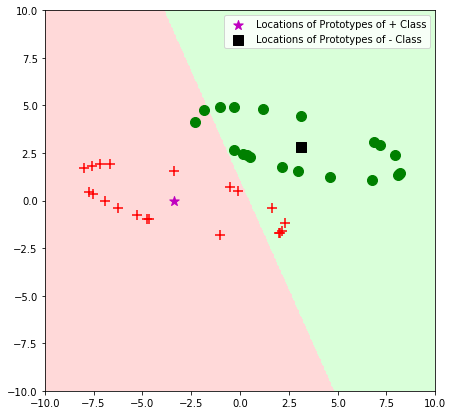

In [7]:
# Refer to 3_Learning with Prototypes.ipynb for details
def LwPBatch( X ):
    return lin.norm( X - protoPos, ord = 2, axis = 1 ) - lin.norm( X - protoNeg, ord = 2, axis = 1 )

# Learn with multiple prototypes per class
def LwMultiPBatch( X ):
    # Get distances from all positive prototypes
    distPos = utils.getAllPairsDistances( X, muPos )
    # Get distances from all negative prototypes
    distNeg = utils.getAllPairsDistances( X, muNeg )
    # Is the closest positive prototype closer or is the closest negative prototype closer?
    return np.min( distPos, axis = 1 ) - np.min( distNeg, axis = 1 )

# Let us generate data where LwP will fail
muPos = np.array( [-3,0] )
muNeg = np.array( [3,3] )
cov = np.array( [[16, -14] , [-14, 16]] )

XPos = gsd.genEllipticalData( d, n, muPos, cov )
XNeg = gsd.genEllipticalData( d, n, muNeg, cov )

# Calculate one prototype for each of the two classes
protoPos = np.sum( XPos, 0 )/n
protoNeg = np.sum( XNeg, 0 )/n

fig4 = pd.getFigure( 7, 7 )
pd.shade2D( LwPBatch, fig3, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig4, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig4, color = 'g', marker = 'o' )
pd.plot2DPoint( protoPos, fig4, color = 'm', marker = '*', label = "Locations of Prototypes of + Class" )
pd.plot2DPoint( protoNeg, fig4, color = 'k', marker = 's', label = "Locations of Prototypes of - Class" )

**Making LwP more powerful using multiple prototypes**: one technique to make the LwP algorithm more powerful is to use more prototypes per class. Clustering can help us find multiple prototypes per class. We will notice that with more prototypes, the LwP algorithm suddenly seems to become capable of learning non-linear decision boundaries, even if using the simple Euclidean distance as the metric.

We should be cautioned that the Lloyd's algorithm struggles more and more with larger values of $k$ (i.e. larger number of clusters) if initialized randomly.

On the other hand, the Lloyd's algorithm offers much better performance if initialized with k-means++. With k-means++, we may even use extremely large values of $k$, for example $k \rightarrow n$ where $n$ is the total number of data points being clustered, and still offer stable solutions. Recall that implementing the LwP algorithm with $k = n$ prototypes simply recovers the 1-nearest neighbor (1NN) algorithm.

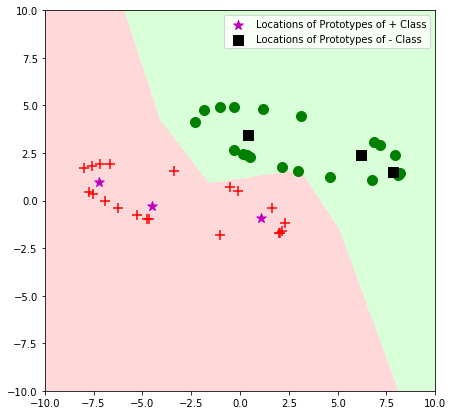

In [8]:
# Let us use 3 prototypes per class
k = 3

# Completely random initializations are not a good idea if k is large
# initPos = np.random.normal( 0, 1, (k,d) )
# initNeg = np.random.normal( 0, 1, (k,d) )

# If you try using larger number of prototypes per class, then k-means++ is definitely better
# k = 10
initPos = doKMPPInit( XPos, k )
initNeg = doKMPPInit( XNeg, k )

(muPos, zPos) = dokmeans( XPos, k, initPos, 10)
(muNeg, zNeg) = dokmeans( XNeg, k, initNeg, 10)

fig4 = pd.getFigure( 7, 7 )
pd.shade2D( LwMultiPBatch, fig4, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig4, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig4, color = 'g', marker = 'o' )
pd.plot2D( muPos, fig4, color = 'm', marker = '*', label = "Locations of Prototypes of + Class" )
pd.plot2D( muNeg, fig4, color = 'k', marker = 's', label = "Locations of Prototypes of - Class" )